<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporando-Pacotes" data-toc-modified-id="Imporando-Pacotes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporando Pacotes</a></span></li><li><span><a href="#Função-de-Entrada" data-toc-modified-id="Função-de-Entrada-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Função de Entrada</a></span></li><li><span><a href="#Dicionários" data-toc-modified-id="Dicionários-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dicionários</a></span></li><li><span><a href="#Cenários" data-toc-modified-id="Cenários-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cenários</a></span></li><li><span><a href="#Otimização" data-toc-modified-id="Otimização-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Otimização</a></span></li></ul></div>

# Imporando Pacotes

In [1]:
# Importando as bibliotecas
import numpy as np # pacote para funções matemáticas
import pandas as pd # pacote para a manipulação dos dados em tabela
import warnings
import itertools
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt # pacote para fazer gráficos
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
import scikitplot as skplt
import sqlite3 as sql

import pandas_ta as ta
import talib

import mplfinance as mpf

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

pd.set_option("display.max_columns", 40)
pd.set_option('display.max_rows', 500)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from futures_backtester import Backtester

# Função de Entrada

In [3]:
import importlib
name_strategy = 'gold_rsi_trend'  # Nome da função/classe no módulo entries
module = importlib.import_module('entries')
entrada = getattr(module, name_strategy)

# Dicionários

In [4]:

path_b3 = 'C:/Users/User/OneDrive/Documentos/rnt/Finance/Trading Projects/00.database/candlestick data/futuros/'
path_tickmill = 'C:/Users/User/OneDrive/Documentos/rnt/Finance/Trading Projects/00.database/tickmill/forex/'

dict_custos = {'WIN@N':0.2*5, 'WDO@N':2.40/2,
                                     'AUDUSD': 3,
                                     'EURUSD': 3,
                                     'GBPUSD': 3,
                                     'NZDUSD': 3,
                                     'USDCHF': 3,
                                     'USDJPY': 3,
                                     'AUDCAD': 3,
                                     'AUDCHF': 3,
                                     'AUDJPY': 3,
                                     'AUDNZD': 3,
                                     'CADCHF': 3,
                                     'CADJPY': 3,
                                     'CHFJPY': 3,
                                     'EURAUD': 3,
                                     'EURCAD': 3,
                                     'EURCHF': 3,
                                     'EURGBP': 3,
                                     'EURHKD': 3,
                                     'EURJPY': 3,
                                     'EURMXN': 3,
                                     'EURNZD': 3,
                                     'EURTRY': 3,
                                     'GBPCAD': 3,
                                     'GBPCHF': 3,
                                     'GBPJPY': 3,
                                     'USDCNH': 3,
                                     'USDCZK': 3,
                                     'USDMXN': 3,
                                     'USDTRY': 3,
                                     'XAGUSD': 3,
                                     'XAUUSD': 3,
                                     'STOXX50': 3,
                                     'UK100': 3,
                                     'FRANCE40': 3,
                                     'VIX': 3,
                                     'ALUMINIUM': 3,
                                     'PLATINUM': 3,
                                     'LEAD': 3,
                                     'NICKEL': 3,
                                     'PALLADIUM': 3,
                                     'ZINC': 3,
                                     'COPPER': 3,
                                     'DXY': 3,
                                     'COCOA': 3,
                                     'SUGAR': 3,
                                     'WHEAT': 3,
                                     'US500': 3,
                                     'NAT.GAS': 3,
                                     'BRENT': 3,
                                     'EEM': 3,
                                     'EWZ': 3,
                                     'IWM': 3,
                                     'TLT': 3,
                                     'SPY': 3,
                                     'DIA': 3}

dict_valor_lot = {'WIN@N':0.2, 'WDO@N':10.0,
                                'USDCAD': 100000,
                                 'AUDUSD': 100000,
                                 'EURUSD': 100000,
                                 'GBPUSD': 100000,
                                 'NZDUSD': 100000,
                                 'USDCHF': 100000,
                                 'USDJPY': 100000,
                                 'AUDCAD': 100000,
                                 'AUDCHF': 100000,
                                 'AUDJPY': 100000,
                                 'AUDNZD': 100000,
                                 'CADCHF': 100000,
                                 'CADJPY': 100000,
                                 'CHFJPY': 100000,
                                 'EURAUD': 100000,
                                 'EURCAD': 100000,
                                 'EURCHF': 100000,
                                 'EURGBP': 100000,
                                 'EURHKD': 100000,
                                 'EURJPY': 100000,
                                 'EURMXN': 100000,
                                 'EURNZD': 100000,
                                 'EURTRY': 100000,
                                 'GBPCAD': 100000,
                                 'GBPCHF': 100000,
                                 'GBPJPY': 100000,
                                 'USDCNH': 100000,
                                 'USDCZK': 100000,
                                 'USDMXN': 100000,
                                 'USDTRY': 100000,
                                 'XAGUSD': 100000,
                                 'XAUUSD': 100000,
                                 'STOXX50': 100000,
                                 'UK100': 100000,
                                 'FRANCE40': 100000,
                                 'VIX': 100000,
                                 'ALUMINIUM': 100000,
                                 'PLATINUM': 100000,
                                 'LEAD': 100000,
                                 'NICKEL': 100000,
                                 'PALLADIUM': 100000,
                                 'ZINC': 100000,
                                 'COPPER': 100000,
                                 'DXY': 100000,
                                 'COCOA': 100000,
                                 'SUGAR': 100000,
                                 'WHEAT': 100000,
                                 'US500': 100000,
                                 'NAT.GAS': 100000,
                                 'BRENT': 100000,
                                 'EEM': 100000,
                                 'EWZ': 100000,
                                 'IWM': 100000,
                                 'TLT': 100000,
                                 'SPY': 100000,
                                 'DIA': 100000}

dict_path = {'WIN@N':path_b3, 'WDO@N':path_b3, 
                              'USDCAD': path_tickmill,
                             'AUDUSD': path_tickmill,
                             'EURUSD': path_tickmill,
                             'GBPUSD': path_tickmill,
                             'NZDUSD': path_tickmill,
                             'USDCHF': path_tickmill,
                             'USDJPY': path_tickmill,
                             'AUDCAD': path_tickmill,
                             'AUDCHF': path_tickmill,
                             'AUDJPY': path_tickmill,
                             'AUDNZD': path_tickmill,
                             'CADCHF': path_tickmill,
                             'CADJPY': path_tickmill,
                             'CHFJPY': path_tickmill,
                             'EURAUD': path_tickmill,
                             'EURCAD': path_tickmill,
                             'EURCHF': path_tickmill,
                             'EURGBP': path_tickmill,
                             'EURHKD': path_tickmill,
                             'EURJPY': path_tickmill,
                             'EURMXN': path_tickmill,
                             'EURNZD': path_tickmill,
                             'EURTRY': path_tickmill,
                             'GBPCAD': path_tickmill,
                             'GBPCHF': path_tickmill,
                             'GBPJPY': path_tickmill,
                             'USDCNH': path_tickmill,
                             'USDCZK': path_tickmill,
                             'USDMXN': path_tickmill,
                             'USDTRY': path_tickmill,
                             'XAGUSD': path_tickmill,
                             'XAUUSD': path_tickmill,
                             'STOXX50': path_tickmill,
                             'UK100': path_tickmill,
                             'FRANCE40': path_tickmill,
                             'VIX': path_tickmill,
                             'ALUMINIUM': path_tickmill,
                             'PLATINUM': path_tickmill,
                             'LEAD': path_tickmill,
                             'NICKEL': path_tickmill,
                             'PALLADIUM': path_tickmill,
                             'ZINC': path_tickmill,
                             'COPPER': path_tickmill,
                             'DXY': path_tickmill,
                             'COCOA': path_tickmill,
                             'SUGAR': path_tickmill,
                             'WHEAT': path_tickmill,
                             'US500': path_tickmill,
                             'NAT.GAS': path_tickmill,
                             'BRENT': path_tickmill,
                             'EEM': path_tickmill,
                             'EWZ': path_tickmill,
                             'IWM': path_tickmill,
                             'TLT': path_tickmill,
                             'SPY': path_tickmill,
                             'DIA': path_tickmill}

# Cenários

In [5]:
# 5 min - win
{'sl': 250, 'tp': 550, 'LENGTH_RSI': 9, 'RSI_LOW': 30, 'RSI_HIGH': 70}
{'sl': 1727, 'tp': 1728, 'LENGTH_RSI': 4, 'RSI_LOW': 36, 'RSI_HIGH': 69} # 10h
{'sl': 630, 'tp': 1500, 'LENGTH_RSI': 7, 'RSI_LOW': 32, 'RSI_HIGH': 50} 
{'sl': 610, 'tp': 1500, 'LENGTH_RSI': 4, 'RSI_LOW': 21, 'RSI_HIGH': 69} # 11h

# 5 min - wdo
{'sl': 18, 'tp': 8, 'LENGTH_RSI': 8, 'RSI_LOW': 28, 'RSI_HIGH': 73}
{'sl': 11, 'tp': 27, 'LENGTH_RSI': 15, 'RSI_LOW': 26, 'RSI_HIGH': 65}
{'sl': 23, 'tp': 31, 'LENGTH_RSI': 11, 'RSI_LOW': 38, 'RSI_HIGH': 62}

{'sl': 18, 'tp': 8, 'LENGTH_RSI': 8, 'RSI_LOW': 28, 'RSI_HIGH': 73}

In [567]:
params = {'sl': 300, 'tp': 550, 'LENGTH_RSI': 9, 'RSI_LOW': 30, 'RSI_HIGH': 70}
params = {'sl': 300, 'tp': 550, 'LENGTH_RSI': 9, 'RSI_LOW': 28, 'RSI_HIGH': 70}
params = {'sl': 300, 'tp': 550, 'LENGTH_RSI': 9, 'RSI_LOW': 28, 'RSI_HIGH': 70}
params = {'sl': 300, 'tp': 550, 'LENGTH_RSI': 10, 'RSI_LOW': 30, 'RSI_HIGH': 70}

#params = {'sl': 0.00800, 'tp': 0.00400, 'LENGTH_RSI': 15, 'RSI_LOW': 35, 'RSI_HIGH': 65}
#params = {'sl': 0.10000, 'tp': 0.30000, 'LENGTH_RSI': 9, 'RSI_LOW': 35, 'RSI_HIGH': 65}
#params = {'sl': 0.10000, 'tp': 0.30000, 'LENGTH_RSI': 9, 'RSI_LOW': 40, 'RSI_HIGH': 60}
#params = {'sl': 300, 'tp': 500, 'LENGTH_RSI': 9, 'RSI_LOW': 30, 'RSI_HIGH': 70}

In [655]:
params = {'sl': 350, 'tp': 550, 'LENGTH_RSI': 10, 'RSI_LOW': 30, 'RSI_HIGH': 70}

In [658]:
# Configurar o backtester
#sym = 'WDO@N'
sym = 'WIN@N'

bt = Backtester(
    symbol = sym,
    timeframe = 't5',
    data_ini = '2019-01-01',
    data_fim = '2025-06-14',
    tp = params['tp'],
    sl = params['sl'],
    slippage = 0,
    tc = dict_custos[sym], # $ per lot
    lote = 1,
    valor_lote= dict_valor_lot[sym],
    initial_cash = 30000,
    path_base= dict_path[sym],
    daytrade = True
)

# Parâmetros da estratégia RSI
LENGTH_RSI = params['LENGTH_RSI']
RSI_LOW = params['RSI_LOW']
RSI_HIGH = params['RSI_HIGH']

# Executa o backtest com a estratégia RSI
results, metrics = bt.run(
    signal_function=entrada, 
    signal_args={
        "length_rsi": LENGTH_RSI,
        "rsi_low": RSI_LOW,
        "rsi_high": RSI_HIGH,
        'allowed_hours': [10,12,13,14,15,16,17],
        #'allowed_hours': [10],
        'position_type': "both"
    }
)

# Print de métricas
bt.print_metrics(metrics)

RELATÓRIO DE DESEMPENHO
Símbolo: WIN@N
Timeframe: t5
Período: 2019-01-01 a 2025-06-14

--- RESULTADOS ---
Saldo Inicial: $30000.00
Saldo Final: $67701.00
Retorno Total: $37701.00 (125.67%)
Retorno Anualizado: 14.10%
Volatilidade Anualizada: 7.14%

--- DRAWDOWN ---
Drawdown Máximo: 4.05%
Drawdown Máximo (Valor): $2453.00
Tempo Máximo em Drawdown: 20063.0 períodos
Tempo em Drawdown: 92.83% do total

--- TRADES ---
Total de Trades: 6153
Trades Vencedores: 2919 (47.44%)
Trades Perdedores: 3218 (52.56%)
Saídas por TP: 29.71%
Saídas por SL: 41.67%
Saídas por Tempo: 28.62%

--- RATIOS ---
Sharpe Ratio: 1.975
Sortino Ratio: 4.056
Calmar Ratio: 3.485
Profit Factor: 1.187

--- ANÁLISE DE GANHOS/PERDAS ---
Ganho Médio: $81.95
Perda Média: $62.62
Win/Loss Ratio: 1.31
Expectancy: $5.96


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 1400x1000 with 0 Axes>

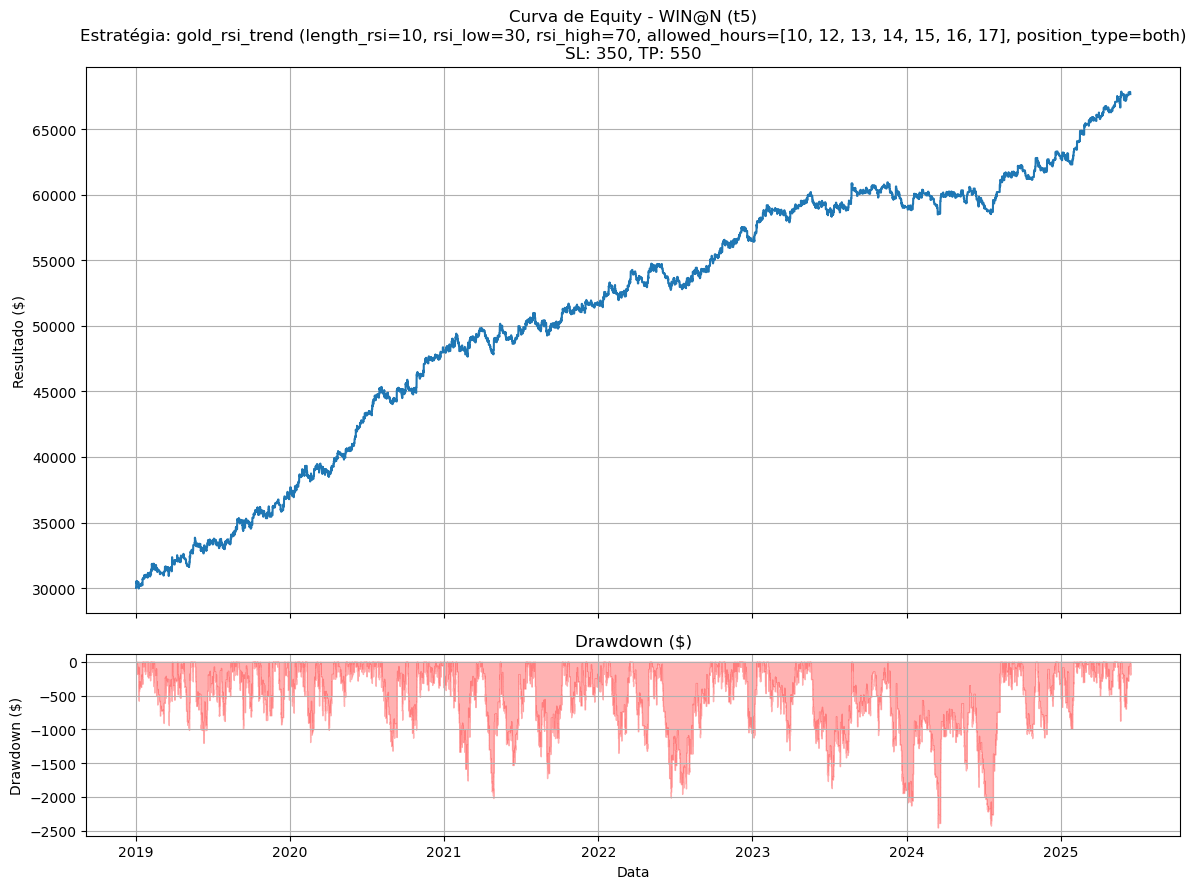

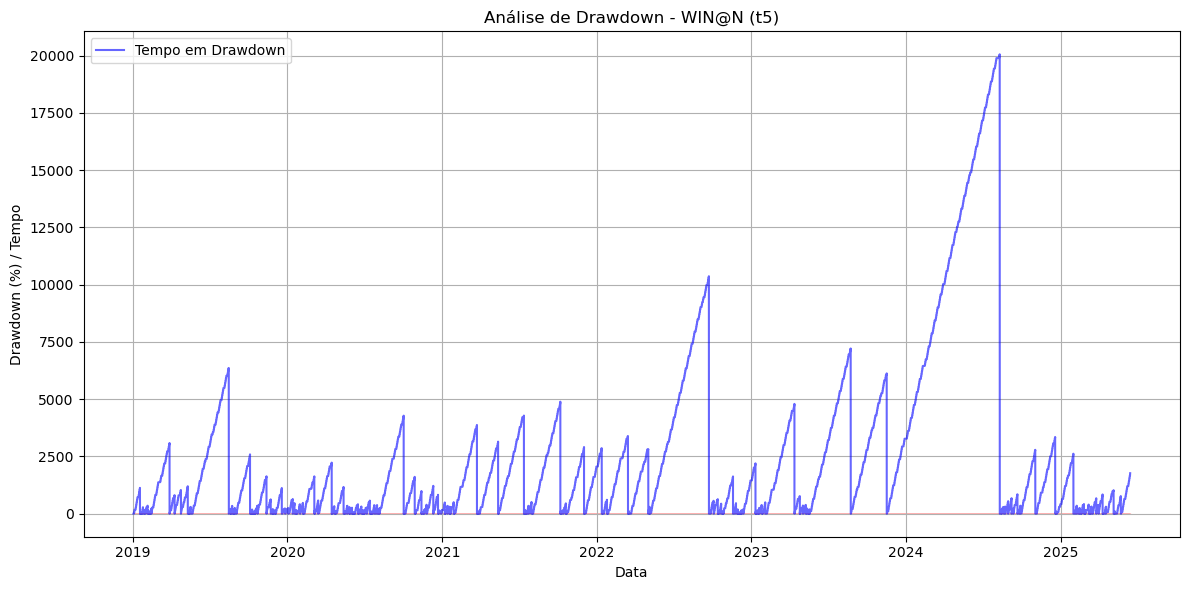

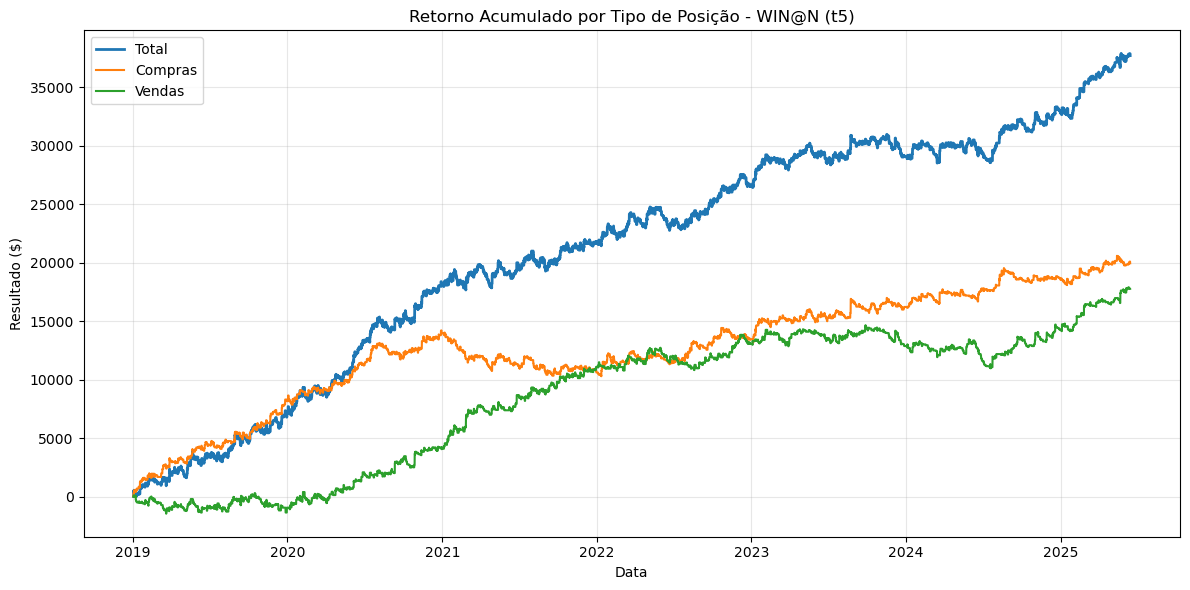

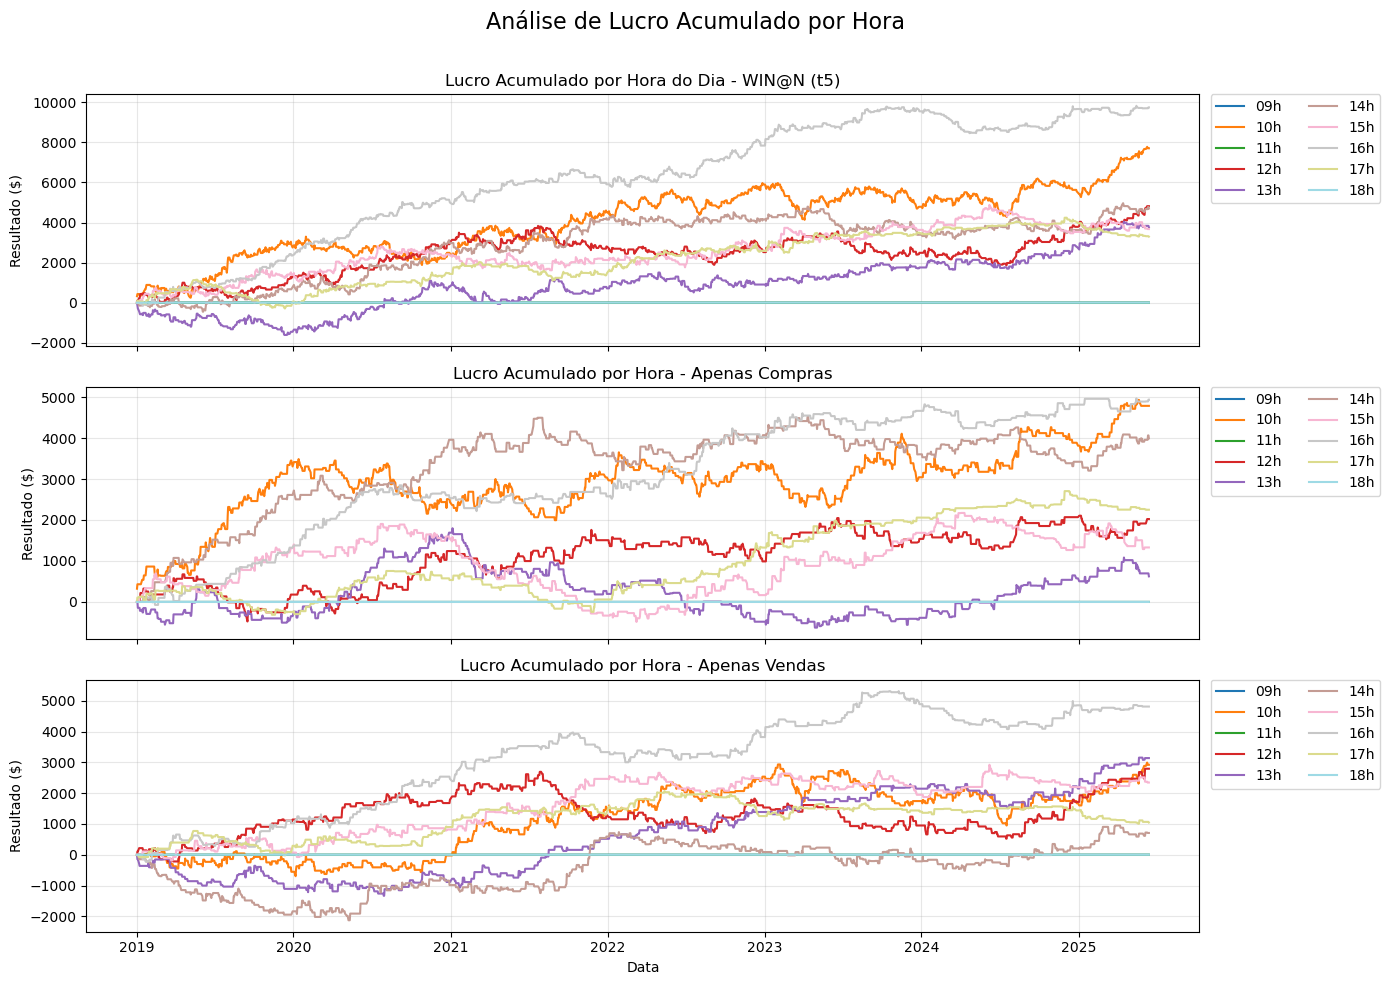

In [659]:
# Plotar a curva de equity com drawdown
plt.figure(figsize=(14, 10))

# 1. Curva de equity
plt = bt.plot_equity_curve(include_drawdown=True)

# 2. Análise detalhada de drawdown
plt = bt.plot_drawdown()

# 3. resultado por hora
bt.plot_by_position()
bt.plot_cumulative_by_hour()

# Otimização

In [416]:
def objective_ind(trial):  
    
    '''
    função para maximizar os ganhos no mini-indice
    '''

    # Configurar o backtester
    sym = 'WIN@N'
    bt = Backtester(
        symbol = sym,
        timeframe = 't5',
        data_ini = '2020-06-01',
        data_fim = '2025-12-31',
        sl = trial.suggest_int('sl', 100.0, 1900.0),
        tp = trial.suggest_int('tp', 100.0, 1900.0),
        slippage = 0,
        tc = dict_custos[sym], # $ per lot
        lote = 1,
        valor_lote= dict_valor_lot[sym],
        initial_cash = 30000,
        path_base= dict_path[sym],
        daytrade = True
    )
    
    # Parâmetros da estratégia RSI
    LENGTH_RSI = trial.suggest_int('LENGTH_RSI', 4, 14)
    RSI_LOW = trial.suggest_int('RSI_LOW', 20, 50)
    RSI_HIGH = trial.suggest_int('RSI_HIGH', 50, 80)
    
    # Executa o backtest com a estratégia RSI
    _, metrics = bt.run(
        signal_function=entrada, 
        signal_args={
            "length_rsi": LENGTH_RSI,
            "rsi_low": RSI_LOW,
            "rsi_high": RSI_HIGH,
            'allowed_hours': [10],
            'position_type': "both"
        }
    )

    
    metrica = metrics['sharpe_ratio']
    #metrica = metrics['max_drawdown_value']
        
    return metrica

In [417]:
study = optuna.create_study(direction="maximize")

study.optimize(objective_ind, n_trials=220)

[I 2025-06-21 14:13:46,862] A new study created in memory with name: no-name-21d90d30-bc26-48cb-bfb0-9218bab31e76
[I 2025-06-21 14:13:47,637] Trial 0 finished with value: 1.39756247607469 and parameters: {'sl': 1844, 'tp': 1667, 'LENGTH_RSI': 12, 'RSI_LOW': 45, 'RSI_HIGH': 77}. Best is trial 0 with value: 1.39756247607469.
[I 2025-06-21 14:13:48,407] Trial 1 finished with value: -0.8345371888331665 and parameters: {'sl': 1761, 'tp': 204, 'LENGTH_RSI': 10, 'RSI_LOW': 49, 'RSI_HIGH': 54}. Best is trial 0 with value: 1.39756247607469.
[I 2025-06-21 14:13:49,172] Trial 2 finished with value: -0.8595330189787845 and parameters: {'sl': 599, 'tp': 199, 'LENGTH_RSI': 10, 'RSI_LOW': 36, 'RSI_HIGH': 66}. Best is trial 0 with value: 1.39756247607469.
[I 2025-06-21 14:13:49,956] Trial 3 finished with value: -0.5520031845174059 and parameters: {'sl': 1353, 'tp': 592, 'LENGTH_RSI': 10, 'RSI_LOW': 21, 'RSI_HIGH': 68}. Best is trial 0 with value: 1.39756247607469.
[I 2025-06-21 14:13:50,729] Trial 4 f

[I 2025-06-21 14:14:16,302] Trial 36 finished with value: 0.419337445560905 and parameters: {'sl': 1898, 'tp': 106, 'LENGTH_RSI': 11, 'RSI_LOW': 42, 'RSI_HIGH': 78}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:17,122] Trial 37 finished with value: 0.1561163384686946 and parameters: {'sl': 1293, 'tp': 821, 'LENGTH_RSI': 9, 'RSI_LOW': 37, 'RSI_HIGH': 72}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:17,922] Trial 38 finished with value: 0.6311010329158827 and parameters: {'sl': 524, 'tp': 479, 'LENGTH_RSI': 13, 'RSI_LOW': 34, 'RSI_HIGH': 75}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:18,715] Trial 39 finished with value: 0.8821342262087959 and parameters: {'sl': 1474, 'tp': 734, 'LENGTH_RSI': 12, 'RSI_LOW': 36, 'RSI_HIGH': 73}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:19,553] Trial 40 finished with value: 0.7231043888883633 and parameters: {'sl': 324, 'tp': 331, 'LENGTH_RSI': 11, 'RSI_LOW': 27

[I 2025-06-21 14:14:45,794] Trial 73 finished with value: 0.6250042293076495 and parameters: {'sl': 649, 'tp': 1302, 'LENGTH_RSI': 9, 'RSI_LOW': 31, 'RSI_HIGH': 67}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:46,584] Trial 74 finished with value: 1.4303954622189912 and parameters: {'sl': 389, 'tp': 1587, 'LENGTH_RSI': 10, 'RSI_LOW': 21, 'RSI_HIGH': 72}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:47,370] Trial 75 finished with value: 0.5882597571969743 and parameters: {'sl': 1850, 'tp': 1545, 'LENGTH_RSI': 11, 'RSI_LOW': 21, 'RSI_HIGH': 72}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:48,166] Trial 76 finished with value: 0.5654258829785997 and parameters: {'sl': 1028, 'tp': 1756, 'LENGTH_RSI': 10, 'RSI_LOW': 40, 'RSI_HIGH': 78}. Best is trial 6 with value: 2.732900461509865.
[I 2025-06-21 14:14:48,954] Trial 77 finished with value: 0.8136342452641598 and parameters: {'sl': 442, 'tp': 1651, 'LENGTH_RSI': 11, 'RSI_LOW

[I 2025-06-21 14:15:15,195] Trial 110 finished with value: 2.3558070360836156 and parameters: {'sl': 325, 'tp': 1382, 'LENGTH_RSI': 13, 'RSI_LOW': 23, 'RSI_HIGH': 74}. Best is trial 108 with value: 2.841300271916448.
[I 2025-06-21 14:15:15,991] Trial 111 finished with value: 2.374560171730299 and parameters: {'sl': 325, 'tp': 1393, 'LENGTH_RSI': 13, 'RSI_LOW': 23, 'RSI_HIGH': 74}. Best is trial 108 with value: 2.841300271916448.
[W 2025-06-21 14:15:16,769] Trial 112 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_4556\2444219689.py", line 31, in objective_ind
    _, metrics = bt.run(
  File "C:\Users\User\OneDrive\Documentos\rnt\Finance\Trading Projects\backtester\futures_backtester\backtester.py", line 210, in run
    return self.df, self.calculate_metrics

KeyboardInterrupt: 

In [418]:
study.best_params

{'sl': 222, 'tp': 1405, 'LENGTH_RSI': 13, 'RSI_LOW': 24, 'RSI_HIGH': 74}

In [ ]:
plot_param_importances(study)